## Material Trade Centralities Analysis

This notebook explores centrality metrics within material trade networks, focusing on individual materials and their cumulative impact across the entire network. By visualizing centrality trends, it highlights key players and their roles in global trade dynamics.

---

### Table of Contents

1. [Introduction](#introduction)
2. [Data Loading and Preparation](#data-loading-and-preparation)
3. [Material Trade Centralities](#material-trade-centralities)
4. [Summed Trade Centralities Over All Materials](#summed-trade-centralities-over-all-materials)

In [1]:
# General Utilities
import os
import warnings
from pathlib import Path

# Data Handling and Processing
import pandas as pd

# Network Analysis
import networkx as nx

# Visualization
import matplotlib.pyplot as plt

# Custom Modules
from dataloader import DataLoader

# Set global visualization and warning options
warnings.filterwarnings("ignore")

### Data Loading and Preparation

In [2]:
# Load and preprocess dataset
hs_code = 282520
hs_label = "Lithium"

In [3]:
# Create dir for exporting plots
export_path = os.path.join("figures", hs_label)
Path(export_path).mkdir(parents=True, exist_ok=True)

In [4]:
# Load and preprocess dataset
loader = DataLoader(hs_code=hs_code)

_initialize_data took 48.9197 seconds


In [5]:
# Returns efficiently handled polar dataframe
df = loader.get_data()

In [6]:
# Extracts the distinct years
years = sorted(df['t'].unique())

In [7]:
# Get aggregated export and import over all products
baseline_df = loader.get_baseline(load_precompute=True)

In [8]:
# Get Networkx representation of baseline_df
yearly_graphs = loader.get_yearly_graphs(years)

In [9]:
yearly_baseline_graph = loader.get_yearly_baseline_graphs(baseline_df, years)

In [10]:
df

,t,export_country,import_country,v,q
0,2002,Australia,Canada,7.627,2.211
1,2002,Australia,Indonesia,15.395,1.120
2,2002,Australia,Ireland,1.874,0.008
3,2002,Australia,Italy,2.748,0.003
4,2002,Australia,New Zealand,5.832,1.422
...,...,...,...,...,...
9944,2022,United States of America,United Kingdom,7347.733,116.959
9945,2022,United States of America,Vietnam,147.514,3.382
9946,2022,Vietnam,South Korea,3.128,0.050
9947,2022,Zimbabwe,China,40.688,4.192


In [11]:
baseline_df

,t,export_country,import_country,v
0,2001,Afghanistan,Algeria,51.995
1,2001,Afghanistan,Andorra,7.921
2,2001,Afghanistan,Anguilla,0.275
3,2001,Afghanistan,Argentina,0.764
4,2001,Afghanistan,Australia,19.359
...,...,...,...,...
643197,2022,eSwatini,United Republic of Tanzania,42002.308
643198,2022,eSwatini,United States of America,13922.881
643199,2022,eSwatini,Uruguay,0.798
643200,2022,eSwatini,Uzbekistan,0.849


### Material Trade Centralities

In [12]:
crises = [
    (2008, 2009, "World Economic Crisis", '#d3d3d3'),
    (2014, 2015, "Oil Price Crash", '#ffa500'),
    (2018, 2020, "Trump vs. China Trade War", '#90ee90'),
    (2020, 2022, "COVID Pandemic", '#add8e6'),
    (2020, 2022, "Chip Crisis", '#e6e6fa'),
    (2022, 2023, "Russian Attack on Ukraine", '#ff9999'),
]

In [13]:
def compute_func_over_time(yearly_graphs, func, weight, **kwargs):
    centrality_data = []
    for year, graph in yearly_graphs.items():
        if weight:
            edge_attribute_keys = {key for _, _, attr in graph.edges(data=True) for key in attr.keys()}
            if weight not in edge_attribute_keys:
                raise ValueError(f"Invalid weight attribute: {weight}")

            if func == nx.degree_centrality:
                total_weight = sum(1 for _, _, _ in graph.edges(data=True))
                metric_values = {node: sum(1 for _, _, _ in graph.edges(node, data=True)) / total_weight
                                 for node in graph.nodes()}
            else:
                metric_values = func(graph, weight=weight, **kwargs)

        for node, value in metric_values.items():
            centrality_data.append({'node': node, 'year': year, func.__name__: value})
    return pd.DataFrame(centrality_data)


In [14]:
def plot_func_trends(centrality_df, top_n, func_name, comment):
    top_nodes = (
        centrality_df.groupby('node')[func_name]
        .mean()
        .nlargest(top_n)
        .index
    )
    name = " ".join(func_name.split("_")).title()
    filtered_df = centrality_df[centrality_df['node'].isin(top_nodes)]
    pivot_df = filtered_df.pivot(index='year', columns='node', values=func_name)

    fig, ax = plt.subplots(figsize=(6, 5))

    pivot_df.plot(ax=ax, marker='o', legend=False)

    overlapping_colors = ['#d3d3d3', '#ffdd44', '#90ee90', '#add8e6', '#e6e6fa', '#ff9999']

    for i, (start, end, label, color) in enumerate(crises):
        ax.axvspan(start, end, color=overlapping_colors[i], alpha=0.5, zorder=0)

    country_handles = [
        plt.Line2D([0], [0], color=ax.lines[i].get_color(), lw=2, marker='o', label=node)
        for i, node in enumerate(top_nodes)
    ]

    crisis_handles = [
        plt.Line2D([0], [0], color=overlapping_colors[i], lw=8, alpha=0.5, label=label)
        for i, (_, _, label, _) in enumerate(crises)
    ]

    fig.legend(
        handles=country_handles + crisis_handles,
        loc="upper center",
        bbox_to_anchor=(0.5, -0.1),
        ncol=2,
        fontsize="small",
        title="Legends"
    )

    plt.title(f'{name} Trends Over Time')
    plt.xlabel('Year')
    plt.xticks(ticks=range(2002, 2024), rotation=90)
    plt.ylabel(name.title())
    plt.grid(color="white")
    plt.tight_layout()
    plt.savefig(os.path.join(export_path, f"{hs_label}_{func_name}{comment.title()}.png"), dpi=300, bbox_inches="tight", format="png")
    plt.show()

In [15]:
def process_visualization(yearly_graphs, func, top_n, weight, comment=""):
    centrality_df = compute_func_over_time(yearly_graphs, func, weight)
    plot_func_trends(centrality_df, top_n, func.__name__, comment)

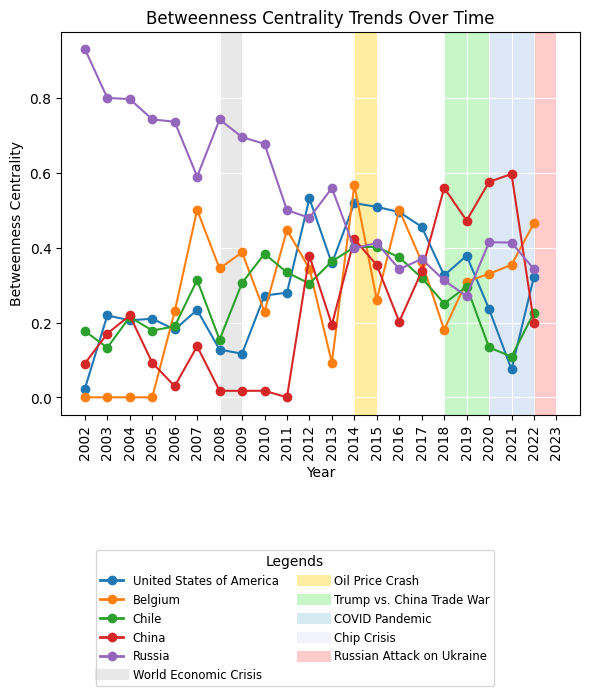

In [16]:
""" Material specific centrality """
func = nx.betweenness_centrality
process_visualization(yearly_graphs, func, top_n=5, weight="inverse_weight")

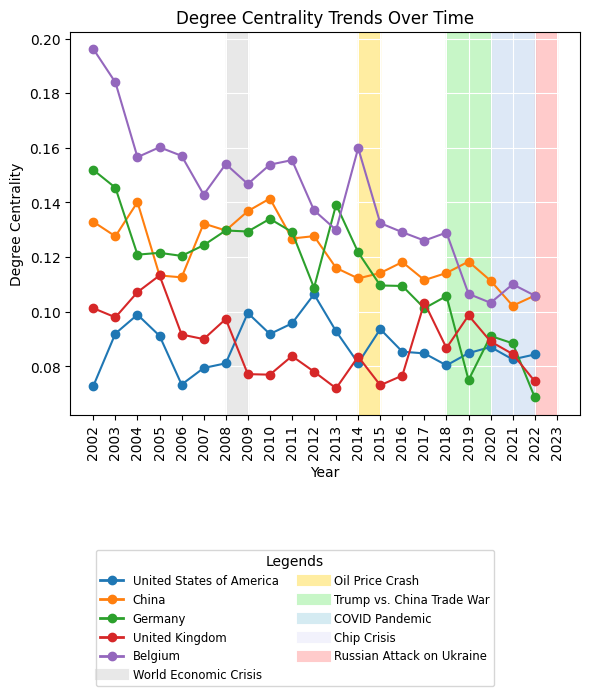

In [17]:
""" Material specific centrality """
func = nx.degree_centrality
process_visualization(yearly_graphs, func, top_n=5, weight="inverse_weight")

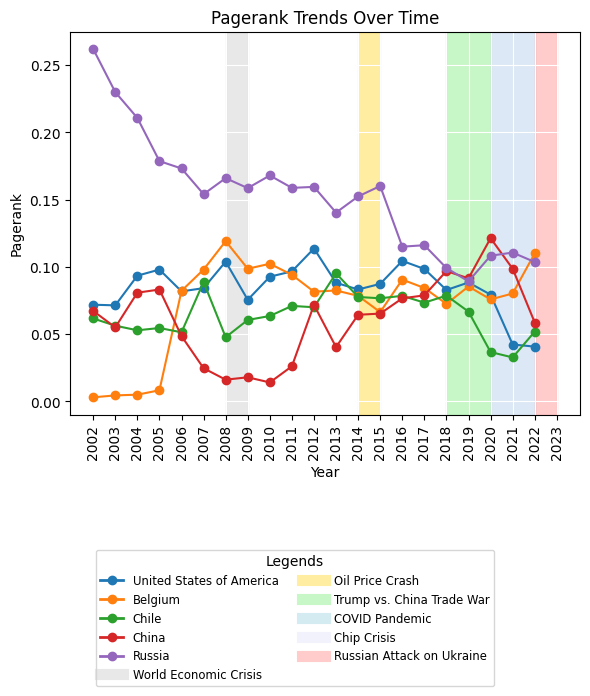

In [18]:
""" Material specific centrality """
func = nx.pagerank
process_visualization(yearly_graphs, func, top_n=5, weight="weight")

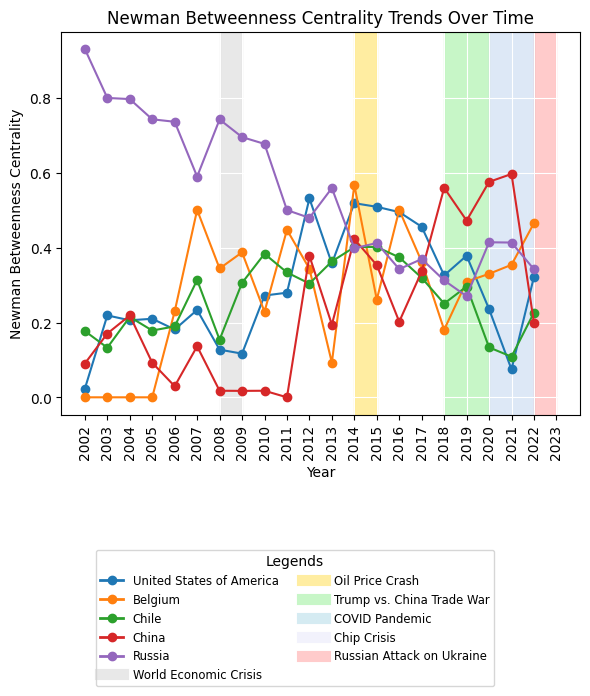

In [19]:
""" Material specific centrality """
func = nx.load_centrality
process_visualization(yearly_graphs, func, top_n=5, weight="inverse_weight")

### Summed Trade Centralities Over All Materials

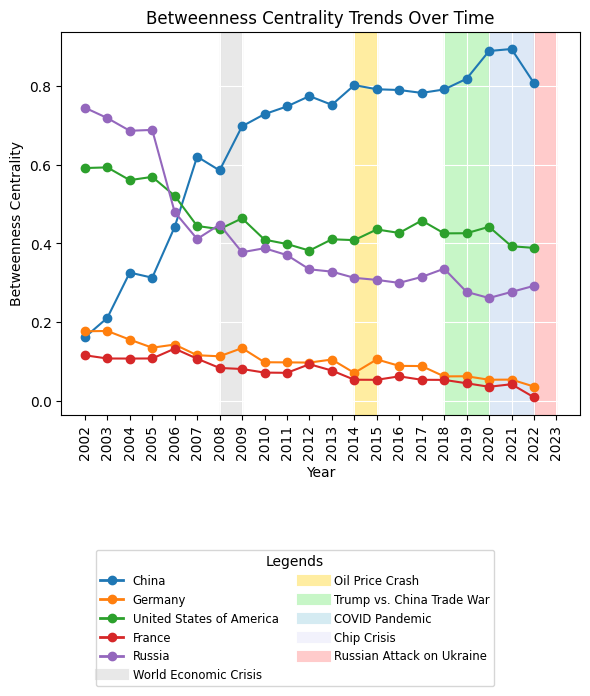

In [20]:
""" Total trade centrality """
func = nx.betweenness_centrality
process_visualization(yearly_baseline_graph, func, top_n=5, weight="inverse_weight", comment="total")

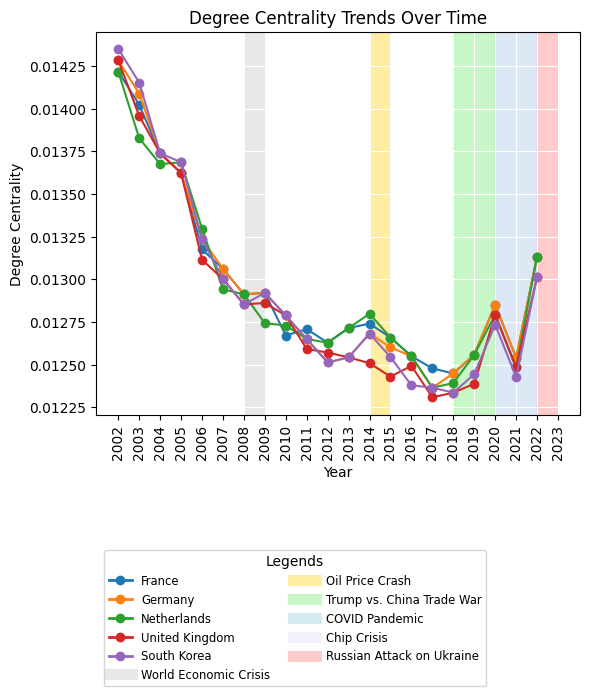

In [21]:
""" Total trade centrality """
func = nx.degree_centrality
process_visualization(yearly_baseline_graph, func, top_n=5, weight="inverse_weight", comment="total")

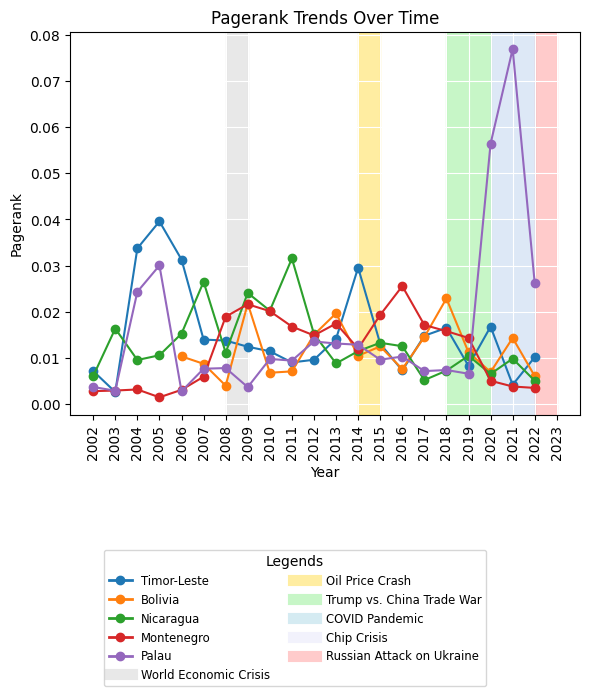

In [22]:
""" Total trade centrality """
func = nx.pagerank
process_visualization(yearly_baseline_graph, func, top_n=5, weight="inverse_weight", comment="total")

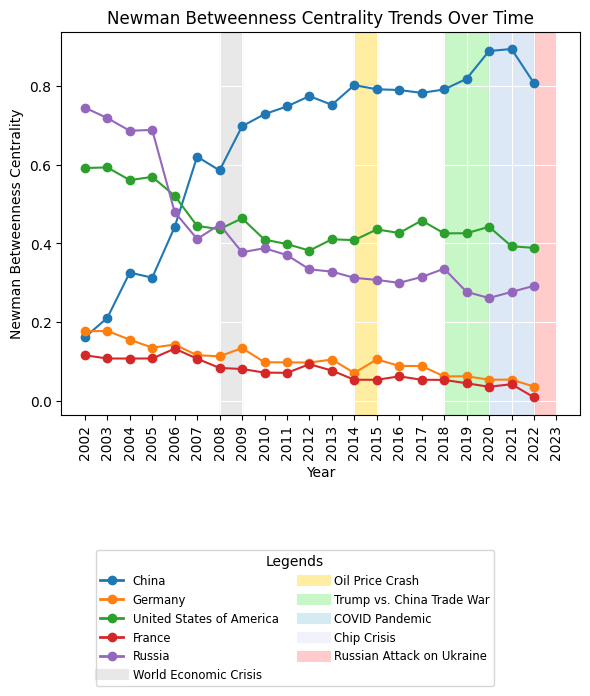

In [23]:
""" Total trade centrality """
func = nx.load_centrality
process_visualization(yearly_baseline_graph, func, top_n=5, weight="inverse_weight", comment="total")